Original tutorial links:
https://www.kaggle.com/mishki/twitter-sentiment-analysis-using-nlp-techniques

https://www.kaggle.com/bamwani/amazon-fine-food-reviews-analysis-using-knn





CODE is based on the authors above with some minor tweaks

# Configuring enivronment and confirming environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
print(sys.executable)

import sys
!{sys.executable} -m pip --version

/usr/bin/python3
pip 19.3.1 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)


# Importing libraries 

In [ ]:
# Importing for numerical computation (numpy) and data processing & manipulation (panadas)
import numpy as np
import pandas as pd

# Importing for data visualization
import matplotlib.pyplot as plt # basic data visualization
import seaborn as sns # nicer data visualization

# for timing code execution
import time

import nltk  
from nltk.tokenize import word_tokenize #tokenizer - 
from nltk.stem import PorterStemmer # to stem words - e.g. transforms the word: abatement to: abat
from nltk.corpus import stopwords #stopwords such as " "
from nltk.sentiment.vader import SentimentIntensityAnalyzer #pre-trained sentiment analyzer 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet



nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')

import re # REGEX (regular expressions)

!pip install gensim
import gensim
from gensim.parsing.preprocessing import remove_stopwords # we also use gensim for stopwords removal

from textblob import TextBlob #pre-trained sentiment analyzer

!pip install flair
from flair.models import TextClassifier #pre-trained sentiment analyzer
from flair.data import Sentence
from segtok.segmenter import split_single

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import and column dropping

In [ ]:
# Loading both twitter datasets
df_don_trump = pd.read_csv('/content/drive/MyDrive/CIND_820/Data/hashtag_donaldtrump.csv', lineterminator='\n')
df_joe_biden = pd.read_csv('/content/drive/MyDrive/CIND_820/Data/hashtag_joebiden.csv', lineterminator='\n')

In [ ]:
print('Total number of records in Trump dataset: ', df_don_trump.shape)
print('Total number of records in Biden dataset: ', df_joe_biden.shape)

trump_initial_count = df_don_trump.shape[0]
biden_initial_count = df_joe_biden.shape[0]

Total number of records in Trump dataset:  (970919, 21)
Total number of records in Biden dataset:  (776886, 21)


In [ ]:
df_don_trump.dtypes

created_at               object
tweet_id                float64
tweet                    object
likes                   float64
retweet_count           float64
source                   object
user_id                 float64
user_name                object
user_screen_name         object
user_description         object
user_join_date           object
user_followers_count    float64
user_location            object
lat                     float64
long                    float64
city                     object
country                  object
continent                object
state                    object
state_code               object
collected_at             object
dtype: object

In [ ]:
df_joe_biden.dtypes

created_at               object
tweet_id                float64
tweet                    object
likes                   float64
retweet_count           float64
source                   object
user_id                 float64
user_name                object
user_screen_name         object
user_description         object
user_join_date           object
user_followers_count    float64
user_location            object
lat                     float64
long                    float64
city                     object
country                  object
continent                object
state                    object
state_code               object
collected_at             object
dtype: object

In [ ]:
# Remove unneeded columns
irrelevant_columns = ['source','user_name','user_screen_name','user_description','user_join_date','collected_at']

# Drop null rows
df_don_trump = df_don_trump.dropna()
df_joe_biden = df_joe_biden.dropna()

# Dealing with country origin and duplicate tweets

In [ ]:
df_don_trump.country.unique()

array(['United States of America', 'United Kingdom', 'The Netherlands',
       'Canada', 'France', 'Australia', 'India', 'Germany', 'Switzerland',
       'Mexico', 'Ireland', 'Ecuador', 'Italy', 'Spain', 'Colombia',
       'Pakistan', 'Peru', 'United Arab Emirates', 'Bangladesh',
       'South Africa', 'Brazil', 'Uruguay', 'Nigeria', 'Belgium',
       'Lebanon', 'Argentina', 'New Zealand', 'Honduras', 'El Salvador',
       'Venezuela', 'Bolivia', 'Philippines', 'Trinidad and Tobago',
       'Papua New Guinea', 'Poland', 'Lithuania', 'Laos', 'Burkina Faso',
       'Sudan', "Côte d'Ivoire", 'Kuwait', 'Syria', 'Oman', 'Slovakia',
       'Suriname', 'Somalia', 'Guyana', 'Cameroon', 'Guatemala', 'Libya',
       'South Sudan'], dtype=object)

In [ ]:
df_joe_biden.country.unique()

array(['United States of America', 'United Kingdom', 'Poland', 'Canada',
       'Germany', 'The Netherlands', 'Switzerland', 'Australia', 'Brazil',
       'India', 'Venezuela', 'United Arab Emirates', 'Ecuador', 'Spain',
       'France', 'Peru', 'Bangladesh', 'Italy', 'Nigeria', 'Argentina',
       'South Africa', 'Belgium', 'New Zealand', 'Mexico', 'Pakistan',
       'Ireland', 'El Salvador', 'Colombia', 'Sudan', 'Bolivia',
       'Lebanon', 'Honduras', 'Uruguay', 'Burkina Faso', 'Philippines',
       'Slovakia', 'Trinidad and Tobago', 'Suriname', 'Laos', 'Lithuania',
       'Libya', 'Syria', 'Guyana', "Côte d'Ivoire", 'Oman', 'Somalia',
       'Guatemala', 'Papua New Guinea', 'Kuwait', 'South Sudan'],
      dtype=object)

In [ ]:
#Remove other countries to capture only tweets originating from the US

df_don_trump_usa = df_don_trump[df_don_trump.country == "United States of America"]
df_joe_biden_usa = df_joe_biden[df_joe_biden.country == "United States of America"]

del df_don_trump
del df_joe_biden

In [ ]:
print('Total number of records in Trump USA dataset: ', df_don_trump_usa.shape)
print('Total number of records in Biden USA dataset: ', df_joe_biden_usa.shape)

Total number of records in Trump USA dataset:  (101967, 15)
Total number of records in Biden USA dataset:  (90642, 15)


In [ ]:
#
tids = df_don_trump_usa.tweet_id
bids = df_joe_biden_usa.tweet_id

ids_tweets_in_common = set(df_don_trump_usa.tweet_id).intersection(set(df_joe_biden_usa.tweet_id))
len(ids_tweets_in_common)

19883

In [ ]:
pd.options.display.max_colwidth = 500 #by default, Python will likely display only the first 50 characters from a long text, increase the column size to solve this

df_joe_biden_usa.tweet.loc[df_joe_biden_usa.tweet_id.isin(list(ids_tweets_in_common))].head(5)

6      In 2020, #NYPost is being #censorship #CENSORED by Twitter to manipulate a US election in favor of #JoeBiden and against #Trump.\n\nbut CCP from #China or porn on Twitter? \n\nThat’s always been fine for @jack @vijaya @dickc @KatieS.\n\n@marciadorsey is @jack sick?
17                               Comments on this? "Do Democrats Understand how Ruthless China is?" https://t.co/QevK00yhs3 #China #HunterBiden #JoeBiden #BidenHarris #BidenHarris2020 #TrumpPence2020 #Trump #realDonaldTrump #WTO #coronavirus #trade https://t.co/Wjm1hyTFNZ
36                                                                                                                                                                               A simple question. Who are you voting for? #2020Election #DonaldTrump #JoeBiden #uspoli #mapoli
131                                     @stephbarlow2 @JoshSchwerin @soledadobrien Disclaimer, totally support dems this #Election2020 but will watch #Trump #FlameShow to nurture th

In [ ]:
df_don_trump_usa_unique = df_don_trump_usa[~df_don_trump_usa['tweet_id'].isin(ids_tweets_in_common)]
df_joe_biden_usa_unique = df_joe_biden_usa[~df_joe_biden_usa['tweet_id'].isin(ids_tweets_in_common)]

In [ ]:
print('Total number of unique records in Trump USA dataset: ', df_don_trump_usa_unique.shape)
print('Total number of unique records in Biden USA dataset: ', df_joe_biden_usa_unique.shape)

Total number of unique records in Trump USA dataset:  (82063, 15)
Total number of unique records in Biden USA dataset:  (70728, 15)


In [ ]:
del df_don_trump_usa
del df_joe_biden_usa

# Languages

In [ ]:
example_tweet = 'El Departamento de Comercio anunció que el formulario Censo 2020 no tendrá la pregunta de ciudadanía de Trump.'

In [ ]:
#try out TextBlob on a sample tweet
from textblob import TextBlob
b = TextBlob(example_tweet)
print(f'Language of text: \n{example_tweet}\nis: {b.detect_language()}')

Language of text: 
#Wisconsin podría ser el punto de inflexión en la carrera entre #Trump y #Biden https://t.co/WFf8A1hAn7
is: es


In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0
detect('El Departamento de Comercio anunció que el formulario Censo 2020 no tendrá la pregunta de ciudadanía de Trump.')

'es'

In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

def get_language(tweet):
    try:                                                          
        lang=detect(tweet)                                      
    except:                                                       
        lang='no'
        
    return lang

In [ ]:
#testing a smaller sample to give a time approximation
start_time = time.time()

test_df = df_don_trump_usa_unique.iloc[:1000].copy()
test_df['lang'] = test_df.tweet.apply(lambda x: get_language(x))

stop_time = time.time()
print(f'It took {np.around((time.time() - start_time),decimals=1)} seconds')

It took 7.8 seconds


In [ ]:
# uncomment to run again 
# start_time = time.time()

# df_don_trump_usa_unique['lang'] = df_don_trump_usa_unique.tweet.apply(lambda x: get_language(x))

# stop_time = time.time()
# print(f'It took {np.around((time.time() - start_time), decimals=1)} seconds')

This tweet throws an error: ⁣
⁣
𝘋𝘰 𝘯𝘰𝘵 𝘷𝘰𝘵𝘦 𝘧𝘰𝘳 #𝘊𝘰𝘷𝘪𝘥𝘪𝘰𝘵𝘐𝘯𝘊𝘩𝘪𝘦𝘧 𝘰𝘳 𝘵𝘩𝘦 #𝘔𝘢𝘴𝘬𝘭𝘦𝘴𝘴𝘋𝘶𝘮𝘣𝘈𝘴𝘴⁣
⁣
𝘕𝘰 𝘮𝘰𝘳𝘦 #𝘛𝘙𝘜𝘔𝘗
This tweet throws an error: I😂😂😂😂😂😂 🤮🤮🤮🤮🤮🤮😂😂😂😂😂🤢🤢🤢🤢🤢🤢🤢🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮😣😣😣😣😣😳😳😳😳😳😳😳😳😳🤮🤮🤮🤮🤮🤮🤮🤮🤢🤢🤢🤢🤢🤢🤒🤒🤒🤒🤒🤒🤒🤒🤒🤒🤒 sums it when I see #trump dancing https://t.co/9BdiBshAVX
This tweet throws an error: @Trailblaze2top #trump ‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼‼
This tweet throws an error: 🆃🆁🆄🅼🅿 2020
🆃🆁🆄🅼🅿 2020
🆃🆁🆄🅼🅿 2020
🆃🆁🆄🅼🅿 2020
🆃🆁🆄🅼🅿 2020
🆃🆁🆄🅼🅿 2020
🆃🆁🆄🅼🅿 2020
🆃🆁🆄🅼🅿 2020
🆃🆁🆄🅼🅿 2020
🆃🆁🆄🅼🅿 2020

RT #ElectionDay #Trump
This tweet throws an error: #Trump 2️⃣0️⃣2️⃣0️⃣🇺🇸🇺🇸🇺🇸❤️🤍💙 https://t.co/57yUuOuiqB
This tweet throws an error: Pennsylvania 👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀👀#BattlegroundState  #Trump #TrumpPence2020 #Vote #PA
This tweet throws an error: 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸
          🇺🇸
          🇺🇸
          🇺🇸
          🇺🇸

🇺🇸🇺🇸🇺🇸🇺🇸

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# uncomment to run again

# start_time = time.time()

# df_joe_biden_usa_unique['lang'] = df_joe_biden_usa_unique.tweet.apply(lambda x: get_language(x))

# stop_time = time.time()
# print(f'It took {np.around((time.time() - start_time), decimals=1)} seconds')

This tweet throws an error: 👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻#JoeBiden https://t.co/9lnd35iOfq
This tweet throws an error: ❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️#Biden https://t.co/9CvcaErqN6
This tweet throws an error: ❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️#joebiden https://t.co/hPFsbGIGQB
This tweet throws an error: 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸#BIDEN https://t.co/njfvCATvn6
This tweet throws an error: 𝗟𝗜𝗦𝗧𝗘𝗡𝗜𝗡𝗚 𝗧𝗢 𝗧𝗛𝗘 𝗦𝗖𝗜𝗘𝗡𝗧𝗜𝗦𝗧 .... 
𝗜 𝘄𝗼𝗻𝗱𝗲𝗿 𝘄𝗵𝗶𝗰𝗵 𝗦𝗰𝗶𝗲𝗻𝘁𝗶𝘀𝘁 #𝗕𝗶𝗱𝗲𝗻 𝘄𝗼𝘂𝗹𝗱𝗻'𝘁 𝗼𝗳 𝗹𝗶𝘀𝘁𝗲𝗻 𝘁𝗼 ..... 𝗛𝗺𝗺𝗺𝗺𝗺 ?????   🤔
https://t.co/xU894RTSaN via @YouTube
This tweet throws an error: 🇺🇸🇺🇸💫💫🇺🇸🇺🇸💫🇺🇸🇺🇸🇺🇸💫💫🇺🇸🇺🇸💫💫🇺🇸💫💫💫🇺🇸💫💫💫💫💫#JoeBiden💫🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸💫💫💫 https://t.co/nX0zcgeB6e
This tweet throws an error: ┏━━┓┏━━┓┏━━┓┏━━┓ ┗━┓┃┃┏┓┃┗━┓┃┃┏┓┃ ┏━┛┃┃┃┃┃┏━┛┃┃┃┃┃ ❤️🤍💙🇺🇲 🅱🅸🅳🅴🅽 🇺🇲❤️🤍💙 ┃┗━┓┃┗┛┃┃┗━┓┃┗┛┃ ┗━━┛┗━━┛┗━━┛┗━━┛
#JoeBiden #VOTE #VoteBlue
This tweet throws an error: ┏━━┓┏━━┓┏━━┓┏━━┓
┗━┓┃┃┏┓┃┗━┓┃┃┏┓┃
❤️🤍💙 🇺🇲 B I D E N 🇺🇲 ❤️🤍💙
┃┗━┓┃┗┛┃┃┗━┓┃┗┛┃
┗━━┛┗━━┛┗━━┛┗━━┛ #Election2020 @TeamJoe #JoeBiden @JoeBiden 🙏🏾🙏🏾🙏🏾
Thi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_don_trump_usa_unique.to_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_don_trump_usa_unique.csv',index=False)
df_joe_biden_usa_unique.to_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_joe_biden_usa_unique.csv', index=False)

In [ ]:
df_don_trump_usa_unique = pd.read_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_don_trump_usa_unique.csv')
df_joe_biden_usa_unique = pd.read_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_joe_biden_usa_unique.csv')

In [ ]:
df_joe_biden_usa_unique.dtypes

created_at               object
tweet_id                float64
tweet                    object
likes                   float64
retweet_count           float64
user_id                 float64
user_followers_count    float64
user_location            object
lat                     float64
long                    float64
city                     object
country                  object
continent                object
state                    object
state_code               object
lang                     object
dtype: object

In [ ]:
df_don_trump_usa_unique.dtypes

created_at               object
tweet_id                float64
tweet                    object
likes                   float64
retweet_count           float64
user_id                 float64
user_followers_count    float64
user_location            object
lat                     float64
long                    float64
city                     object
country                  object
continent                object
state                    object
state_code               object
lang                     object
dtype: object

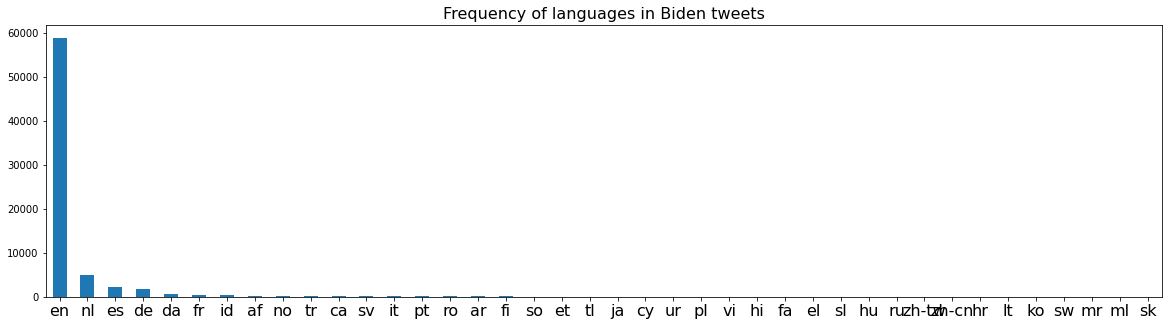

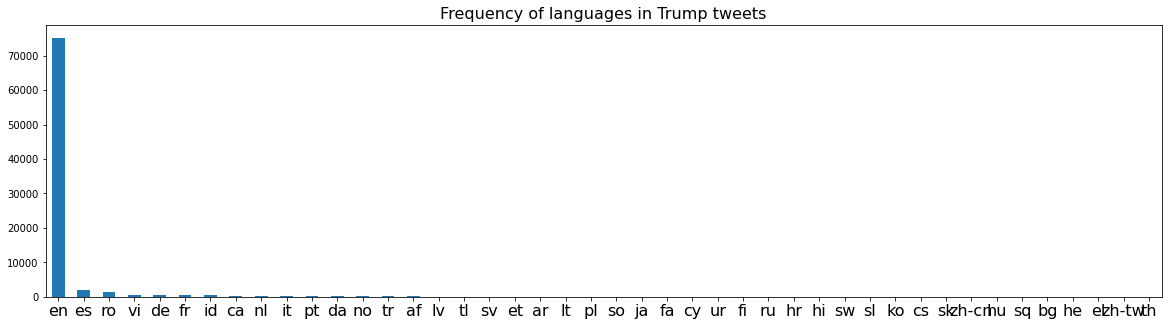

In [ ]:
plt.figure(figsize=(20,5))
ax = df_joe_biden_usa_unique.lang.value_counts().plot.bar(rot=0)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.title('Frequency of languages in Biden tweets', fontsize=16)
plt.show()

plt.figure(figsize=(20,5))
ax = df_don_trump_usa_unique.lang.value_counts().plot.bar(rot=0)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.title('Frequency of languages in Trump tweets',fontsize=16)

plt.show()

In [ ]:
#shortening length of name to make it easier to type
df_trump = df_don_trump_usa_unique.copy()
# del df_don_trump_usa_unique

df_biden = df_joe_biden_usa_unique.copy()
# del df_joe_biden_usa_unique

In [ ]:
df_trump = df_trump[df_trump.lang == 'en']
df_biden = df_biden[df_biden.lang == 'en']


In [ ]:
print('Total number of records in Trump dataset: ', df_trump.shape)
print('Total number of records in Biden dataset: ', df_biden.shape)

Total number of records in Trump dataset:  (75148, 16)
Total number of records in Biden dataset:  (58876, 16)


In [ ]:
print(f'Retained {np.around(df_trump.shape[0]*100/trump_initial_count, decimals=1)}% of dat from the initial Trump dataset')
print(f'Reatined {np.around(df_biden.shape[0]*100/biden_initial_count, decimals=1)}% of data from the initial Biden dataset')

Retained 7.7% of dat from the initial Trump dataset
Reatined 7.6% of data from the initial Biden dataset


# Summary stats

In [ ]:
#create a column for filter

df_trump['ds'] = 'trump'
df_biden['ds'] = 'biden'

# Combine the filtered Trump and Biden Datasets 
df_concat_tweets = pd.concat([df_biden, df_trump],ignore_index=True)

# Covnert the created at colum to datetime
df_concat_tweets['created_at'] =  pd.to_datetime(df_concat_tweets['created_at'])

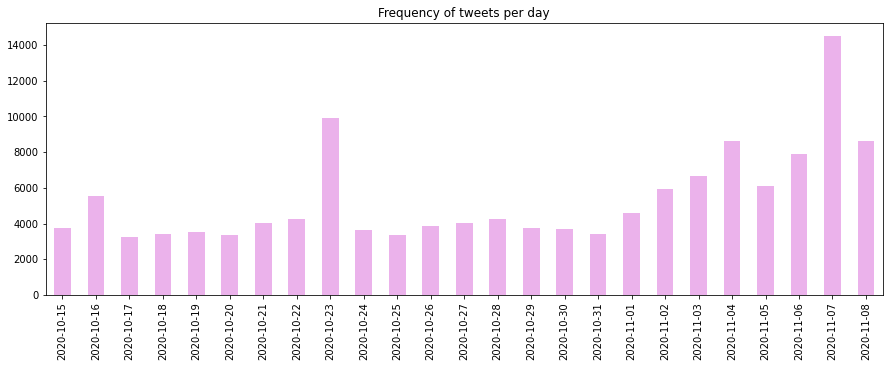

In [ ]:
plt.figure(figsize=(15,5))

df_concat_tweets.created_at.dt.date.value_counts().sort_index().plot.bar(rot=90, alpha=0.3,color='m')

plt.setp(ax.get_xticklabels(), fontsize=16)
plt.title('Frequency of tweets per day')
plt.show()

In [ ]:
most_popular_tweet = df_concat_tweets.loc[df_concat_tweets['retweet_count'].idxmax()]
print(f" The tweet:\n'{most_popular_tweet.tweet}'\nwas retweeted the most ({most_popular_tweet.retweet_count} times).")

 The tweet:
'Tonight a woman in the audience of Trump's town hall began her question by telling him he has a great smile &amp; he's so handsome when he smiles. And when #JoeBiden is President, hopefully that woman will be able to access better vision care, bless her heart.'
was retweeted the most (17652.0 times).


In [ ]:
df_concat_tweets[['tweet_id','user_id','created_at', 'likes', 'retweet_count', 'tweet', 'ds']].iloc[df_concat_tweets.retweet_count.sort_values(ascending=False).head(5).index]

,tweet_id,user_id,created_at,likes,retweet_count,tweet,ds
2388,1.316941e+18,139823781.0,2020-10-16 03:17:29,165702.0,17652.0,"Tonight a woman in the audience of Trump's town hall began her question by telling him he has a great smile &amp; he's so handsome when he smiles. And when #JoeBiden is President, hopefully that woman will be able to access better vision care, bless her heart.",biden
21157,1.320927e+18,139823781.0,2020-10-27 03:16:27,59403.0,7489.0,"Are you there, God? It's me, Bette. I'm so scared God. We have a fascist in the #WhiteHouse, a racist criminal who hates democracy, denies science &amp; kills our citizens! #ElectionDay is next week. What if he wins? We won't have a country! Please let #JoeBiden win. Thank you.",biden
29398,1.323002e+18,139823781.0,2020-11-01 20:41:36,45540.0,6133.0,"Are you there, God? It's me again, Bette. We're scared. We have a fascist in the #WhiteHouse, a racist criminal who hates democracy, denies science &amp; kills our citizens! #ElectionDay is in two days. What if he wins? We won't have a country! Please let #JoeBiden win. Thank you.",biden
1829,1.316908e+18,139823781.0,2020-10-16 01:04:10,43399.0,6038.0,OMG! #JoeBiden speaks like a human being! And he’s actually answering the questions! It’s so exciting! How we have missed this for 4 years!!,biden
87374,1.320518e+18,212674482.0,2020-10-26 00:08:24,25987.0,5986.0,The White House still has not released a health care plan. #60Minutes #Trump https://t.co/hvz3VUE1J2,trump


In [ ]:
print(f'Our 2nd most popular tweet was retweeted for number of times equal to {np.around(13500*100/df_concat_tweets.shape[0], decimals=1)}% of our dataset size')

Our 2nd most popular tweet was retweeted for number of times equal to 10.1% of our dataset size


In [ ]:
df_concat_tweets[df_concat_tweets.tweet.str.contains('Are you there')][['created_at', 'tweet', 'user_id']]

,created_at,tweet,user_id
21157,2020-10-27 03:16:27,"Are you there, God? It's me, Bette. I'm so scared God. We have a fascist in the #WhiteHouse, a racist criminal who hates democracy, denies science &amp; kills our citizens! #ElectionDay is next week. What if he wins? We won't have a country! Please let #JoeBiden win. Thank you.",1.398238e+08
21161,2020-10-27 03:19:27,"Are you there, God? We have a fascist in the #WhiteHouse, a racist criminal who hates democracy, denies science &amp; kills our citizens! #ElectionDay is next week. What if he wins? We won't have a country! Please, please let #JoeBiden win. \nThank you.\nI love you @BetteMidler https://t.co/qubp3F7ZA1",2.366092e+09
29398,2020-11-01 20:41:36,"Are you there, God? It's me again, Bette. We're scared. We have a fascist in the #WhiteHouse, a racist criminal who hates democracy, denies science &amp; kills our citizens! #ElectionDay is in two days. What if he wins? We won't have a country! Please let #JoeBiden win. Thank you.",1.398238e+08


In [ ]:
print(f'There are {df_concat_tweets.retweet_count.nunique()} different amounts of retweets')

There are 519 different amounts of retweets


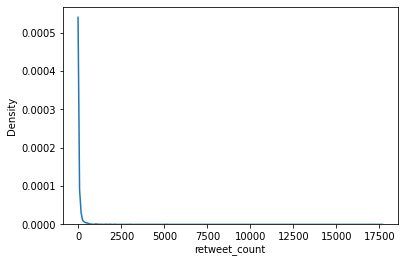

In [ ]:
sns.kdeplot(x='retweet_count', data=df_concat_tweets)

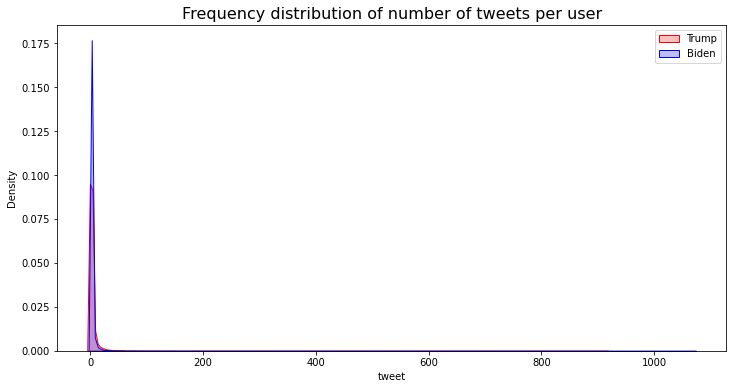

In [ ]:
fig, ax=plt.subplots(1,1, figsize=(12,6))

ax.set_title('Frequency distribution of number of tweets per user', fontsize = 16)
sns.kdeplot(df_trump.groupby(['user_id'])['tweet'].count(), shade=True, color='r', label='Trump', ax = ax)
sns.kdeplot(df_biden.groupby(['user_id'])['tweet'].count(), shade=True, color='b', label='Biden', ax = ax)
labels= ["Trump", "Biden"]
ax.legend(labels)
#ax.set_ylim(0, .005)
plt.show()

# Languages Clean

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(tweet, lemmatize = 'nltk'):

    tweet = tweet.lower() # lowercase
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE) # remove urls
    tweet = re.sub(r'\@\w+|\#','', tweet) # remove mentions of other usernames and the hashtag character
    tweet = remove_stopwords(tweet) # remove stopwords with Gensim

    if (lemmatize == 'spacy'):
        # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
        nlp = spacy.load('en', disable=['parser', 'ner'])
        doc = nlp(tweet)
        tokenized = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    elif (lemmatize == 'nltk'): 
        '''
        lemmatization works best when WordNetLemmatizer receives both the text and the part of speech of each word
        the code below assigns POS (part of speech) tag on a per word basis (it does not infer POS from contenxt / sentence), which might not be optimal
        '''
        lemmatizer = WordNetLemmatizer()
        tokenized = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(tweet)]
    
    # remove left over stop words with nltk
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # remove non-alpha characters and keep the words of length >2 only
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]

    return tokenized

def combine_tokens(tokenized): 
    non_tokenized = ' '.join([w for w in tokenized])
    return non_tokenized

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df_tweets_nltk = df_concat_tweets.copy() 

In [ ]:
start =  time.time()

df_tweets_nltk['tokenized_tweet_nltk'] = df_tweets_nltk['tweet'].apply(lambda x: clean_text(x, 'nltk'))
df_tweets_nltk['clean_tweet_nltk'] = df_tweets_nltk['tokenized_tweet_nltk'].apply(lambda x: combine_tokens(x))

stop = time.time()
print(f'Cleaning all tweets takes ~{round((stop-start)/60, 3)} minutes: ')

Cleaning all tweets takes ~10.967 minutes: 


In [ ]:
# df_tweets_nltk.to_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_tweets_nltk.csv',index=False)

In [ ]:
# df_tweets_nltk = pd.read_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_tweets_nltk.csv')

In [ ]:
df_tweets_nltk [df_tweets_nltk.tweet_id.isin(list(df_trump.tweet_id))].ds = 'trump'
df_tweets_nltk[df_tweets_nltk.tweet_id.isin(list(df_biden.tweet_id))].ds = 'biden'

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_tweets_nltk.head(10)[['tweet', 'clean_tweet_nltk']]

,tweet,clean_tweet_nltk
0,Twitter is doing everything they can to help Democrats win the election. Making sure nobody sees a negative story about Biden. Only Negative stories on Trump. #TwitterCensorship #Biden #Ukraine #HunterBiden https://t.co/dbLKQBMvRU,twitter help democrat win election make sure see negative story biden negative story trump twittercensorship biden ukraine hunterbiden
1,Come on @ABC PLEASE DO THE RIGHT THING. Move the #biden town hall. I bet a requirement for Orange Monkey to do the NBC town hall was to have it opposite Biden. PLEASE MOVE YOURS.,come right thing biden town hall bet requirement orange monkey nbc town hall opposite biden
2,"#realDonaldTrump addresses #JoeBiden and #HunterBiden corruption, more proof of which discovered on a laptop.\n#ObamaBidenGate #NYPost #MSNBC #CBS #NBC #ABC #FoxNews #KamalaHarris https://t.co/7RtMOdoXGd",realdonaldtrump address joebiden hunterbiden corruption proof discover laptop obamabidengate nypost msnbc cbs nbc abc foxnews kamalaharris
3,"Hunter #Biden introduced his father, then-Vice President Joe Biden, to a top executive at a Ukrainian energy firm less than a year before the elder Biden pressured government officials in Ukraine into firing a prosecutor who was investigating the company, according to emails",hunter biden introduce father president joe biden executive ukrainian energy firm year elder biden pressure government official ukraine fire prosecutor investigate company accord email
4,This is from the same night I met the cast of #TWW and I was wearing the same shirt as @AllisonBJanney 😍\n\n#VOTE #voteblue #JoeBiden #LoveTrumpsHate https://t.co/aESuB1ipBq,night met cast tww wear shirt vote voteblue joebiden lovetrumpshate
5,"@realDonaldTrump #TrumpIsALaughingStock @realDonaldTrump at his Iowa cult rally compared #JoeBiden to Putin, XI, and Kim Jong-un. In the same sentence he called @JoeBiden “shot” and all 3 communist leaders “SHARP”\n\n#TrumpIsANationalDisgrace",trumpisalaughingstock iowa cult rally compare joebiden putin kim sentence call shot communist leader sharp trumpisanationaldisgrace
6,"Laptop computer abandoned at Delaware repair shop contains #emails between #HunterBiden &amp; senior #Burisma #adviser indicating Hunter arranged a meeting between then VP #JoeBiden &amp; the adviser in Washington, DC in 2015.\nJoe Biden Calls a Lid &amp; Hides https://t.co/X1ynqJzbUN",laptop abandon delaware repair shop contains email hunterbiden amp senior burisma adviser indicate hunter arrange meeting joebiden amp adviser washington joe biden call lid amp hide
7,"Vice President #Biden is 77 years young.\nI am willing to bet that he has a long list of things he’d rather focus on and enjoy life, than cleaning up 🧹 the deadly mess left by spineless republicans and #DonTheCon \nHis only motive is to #BuildBackBetter #VoteForDemocracy #Vote",vice president biden year young willing bet long list thing focus enjoy life cleaning deadly mess left spineless republican donthecon motive buildbackbetter votefordemocracy vote
8,"So the #FBI received the LAPTOP with the EMAILS and instead of acting on behalf of the American people and pursuing justice, they pushed it under the rug to cover up for #JoeBiden \n#HunterBidenEmails\n\n#ChristopherWray \nResign Now!",fbi receive laptop email instead act behalf american people pursue justice push rug cover joebiden hunterbidenemails christopherwray resign
9,And Trump claims Biden has dementia? \n#DonaldOut #TrumpRally #trumpDementia #Biden #Vote #TrumpIsNotAmerica #MAGA #StopTrumpsTerror https://t.co/cuvce2uIpT,trump claim biden dementia donaldout trumprally trumpdementia biden vote trumpisnotamerica maga stoptrumpsterror


# Text blob

In [ ]:
def create_sentiment_labels(df, feature,value):
    '''
    in: 
        dataframe 
        value on which to classify
        feature - column name of the feature that receives the label
    out: 
        does not return a value
        modifies the dataframe received as parameter
    '''

    df.loc[df[value] > 0,feature] = 'positive'
    df.loc[df[value] == 0,feature] = 'neutral'
    df.loc[df[value] < 0,feature] = 'negative'

In [ ]:
# Polarity and subjectivity
def sentiment_analysis(dataframe):
    dataframe['blob_polarity'] = dataframe['clean_tweet_nltk'].apply(lambda x: TextBlob(x).sentiment.polarity)
    dataframe['blob_subjectivity'] = dataframe['clean_tweet_nltk'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    create_sentiment_labels(dataframe, 'blob_sentiment','blob_polarity')
    
    return dataframe[['clean_tweet_nltk','blob_polarity','blob_subjectivity','blob_sentiment']].head()   

In [ ]:
# df_tweets_nltk['clean_tweet_nltk'].astype(str).astype(int)

In [ ]:
# df_tweets_nltk['clean_tweet_nltk'].apply(lambda x: sentiment_analysis(' '.join(x)))

In [ ]:
start =  time.time()

sentiment_analysis(df_tweets_nltk)

stop = time.time()
print(f'Sentiment analysis with TextBlob took: {round((stop-start)/60, 3)} minutes')

Sentiment analysis with TextBlob took: 0.802 minutes


In [ ]:
df_tweets_nltk.head(10)[['blob_polarity','blob_subjectivity', 'blob_sentiment']]

,blob_polarity,blob_subjectivity,blob_sentiment
0,0.175000,0.522222,positive
1,0.078571,0.178571,positive
2,0.000000,0.000000,neutral
3,-0.200000,0.400000,negative
4,0.000000,0.000000,neutral
5,-0.125000,0.750000,negative
6,0.000000,0.000000,neutral
7,0.087500,0.370833,positive
8,0.000000,0.000000,neutral
9,0.000000,0.000000,neutral


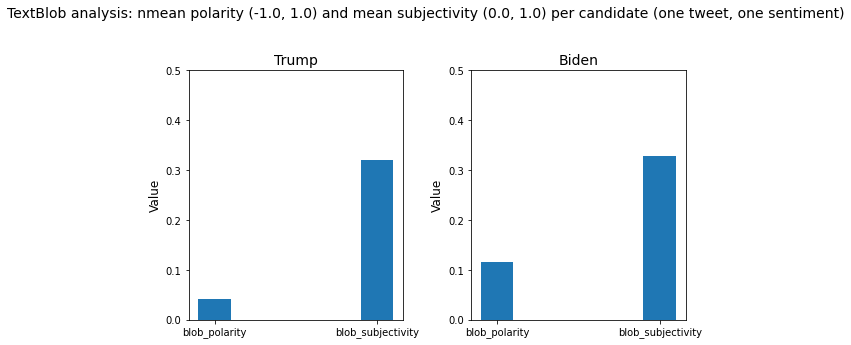

In [ ]:
#update the divided dataset
df_trump = df_tweets_nltk[df_tweets_nltk.ds=='trump']
df_biden = df_tweets_nltk[df_tweets_nltk.ds=='biden']

fig, axes = plt.subplots(1, 2, figsize=(8,5))

fig.suptitle('TextBlob analysis: nmean polarity (-1.0, 1.0) and mean subjectivity (0.0, 1.0) per candidate (one tweet, one sentiment)', fontsize=14)

features = ['blob_polarity', 'blob_subjectivity']
values = [df_trump.groupby(['user_id'])['blob_polarity'].mean().mean(), df_trump.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[0].bar(features,values, width=0.2)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 14)
axes[0].set_ylabel('Value', fontsize = 12)

values = [df_biden.groupby(['user_id'])['blob_polarity'].mean().mean(), df_biden.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[1].bar(features,values, width=0.2)
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 14)
axes[1].set_ylabel('Value', fontsize = 12)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

trump_usa_pol_tweet =df_trump['blob_polarity'].mean()
trump_usa_subj_tweet = df_trump['blob_subjectivity'].mean()
biden_usa_pol_tweet = df_biden['blob_polarity'].mean()
biden_usa_subj_tweet = df_biden['blob_subjectivity'].mean()

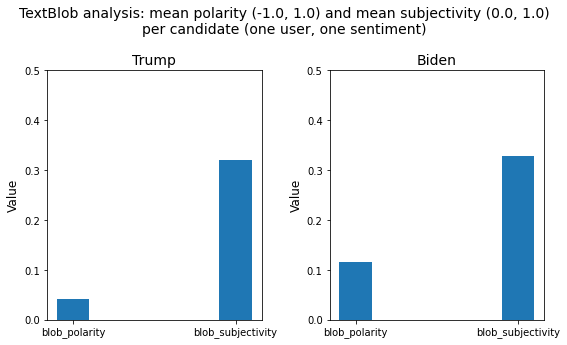

In [ ]:
# the below gives us a mean per user
# df_trump_usa[['user_id', 'Polarity']].groupby(['user_id'])['Polarity'].mean()

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

fig.suptitle('TextBlob analysis: mean polarity (-1.0, 1.0) and mean subjectivity (0.0, 1.0)\nper candidate (one user, one sentiment)', fontsize=14)

features = ['blob_polarity', 'blob_subjectivity']
values = [df_trump.groupby(['user_id'])['blob_polarity'].mean().mean(), df_trump.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[0].bar(features,values, width=0.2,)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 14)
axes[0].set_ylabel('Value', fontsize = 12)

values = [df_biden.groupby(['user_id'])['blob_polarity'].mean().mean(), df_biden.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[1].bar(features,values, width=0.2,)
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 14)
axes[1].set_ylabel('Value', fontsize = 12)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

trump_usa_pol_user = df_trump.groupby(['user_id'])['blob_polarity'].mean().mean()
trump_usa_subj_user = df_trump.groupby(['user_id'])['blob_subjectivity'].mean().mean()
biden_usa_pol_user = df_biden.groupby(['user_id'])['blob_polarity'].mean().mean()
biden_usa_subj_user = df_biden.groupby(['user_id'])['blob_subjectivity'].mean().mean()

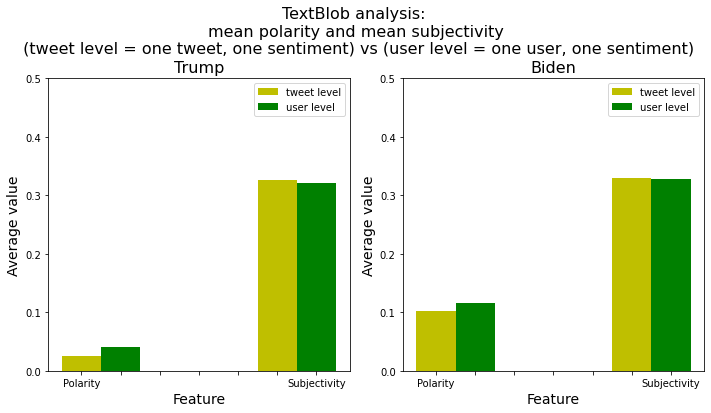

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

fig.suptitle('TextBlob analysis: \nmean polarity and mean subjectivity\n (tweet level = one tweet, one sentiment) vs (user level = one user, one sentiment)', fontsize=16)

#features = ['Polarity', 'Subjectivity']
features = np.array([1, 2])
values_tweet = [ trump_usa_pol_tweet, trump_usa_subj_tweet]
values_user = [ trump_usa_pol_user, trump_usa_subj_user]

#values = [[trump_usa_pol_tweet, trump_usa_subj_tweet], 
#[trump_usa_pol_user, trump_usa_subj_user]]

axes[0].bar(features-0.2, values_tweet, width=0.2, align = 'center', color = 'y')
axes[0].bar(features, values_user, width=0.2, align = 'center', color = 'g')
#axes[0].bar(features,values)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Feature', fontsize = 14)
axes[0].set_ylabel('Average value', fontsize = 14)
axes[0].set_xticklabels(['', 'Polarity', '', '', '', '', '', 'Subjectivity'])
labels= ["tweet level", "user level"]
axes[0].legend(labels)

values_tweet = [ biden_usa_pol_tweet, biden_usa_subj_tweet]
values_user = [ biden_usa_pol_user, biden_usa_subj_user]
axes[1].bar(features-0.2,values_tweet, width=0.2, align = 'center', color = 'y')
axes[1].bar(features,values_user, width=0.2, align = 'center', color = 'g')
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Feature', fontsize = 14)
axes[1].set_ylabel('Average value', fontsize = 14)
axes[1].set_xticklabels(['', 'Polarity', '', '', '', '', '', 'Subjectivity'])

labels= ["tweet level", "user level"]
axes[1].legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

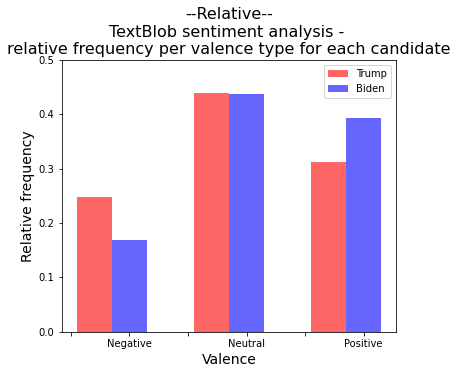

In [ ]:
plt.figure(figsize=(6,5))

ax = plt.gca()
ax.set_title('--Relative--\nTextBlob sentiment analysis - \nrelative frequency per valence type for each candidate', fontsize=16)

features = np.array([1,2,3])
trump = (df_trump['blob_sentiment'].sort_values().value_counts()/df_trump['blob_sentiment'].shape[0])[['negative', 'neutral', 'positive']]
ax.bar(features-0.3, trump.values, width=0.3, align = 'center', color = 'r', alpha= .6)

biden = (df_biden['blob_sentiment'].sort_values().value_counts()/df_biden['blob_sentiment'].shape[0])[['negative', 'neutral', 'positive']]
ax.bar(features, biden.values, width=0.3, align = 'center', color = 'b', alpha= .6)

ax.set_ylim(0, .5)
ax.set_xlabel('Valence', fontsize = 14)
ax.set_ylabel('Relative frequency', fontsize = 14)

ax.set_xticklabels(['', '', 'Negative', '', 'Neutral', '', 'Positive'])

labels= ["Trump", "Biden"]
ax.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

# Vader

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
def sentiment_analysis_vader(df, clean = True):
    if clean:
        target_col = 'clean_tweet_nltk'
        prefix = 'vader_clean_'
    else:
        target_col = 'tweet'
        prefix = 'vader_'
    
    scores_col = prefix+'scores'
    
    #let's make it vader_sentiment, so that it has the same naming convention as TextBlob and Flair sentiment score
    #compound_col = prefix+'compound'
    compound_col = prefix+'polarity'
    
    #comp_score_col = prefix+'comp_score'
    comp_score_col = prefix+'sentiment' 
    
    df[scores_col] = df[target_col].apply(lambda tweet: sid.polarity_scores(tweet))
    df[compound_col] = df[scores_col].apply(lambda d: d['compound'])
    create_sentiment_labels(df,comp_score_col,compound_col)

In [ ]:
start = time.time()

sentiment_analysis_vader(df_tweets_nltk)
sentiment_analysis_vader(df_tweets_nltk, clean = False)

stop = time.time()
print(f'Sentiment analysis with VADER took: {round((stop-start)/60, 3)} minutes')

#update the divided dataset
df_trump = df_tweets_nltk[df_tweets_nltk.ds=='trump']
df_biden = df_tweets_nltk[df_tweets_nltk.ds=='biden']

Sentiment analysis with VADER took: 1.116 minutes


In [ ]:
from sklearn.metrics import accuracy_score

start = time.time()

print(f"Accuracy score for our cleaning vs vader tweet cleaning for Trump: {accuracy_score(df_trump['vader_sentiment'],df_trump['vader_clean_sentiment']):.4}")
print(f"Accuracy score for our cleaning vs vader tweet cleaning for Biden: {accuracy_score(df_biden['vader_sentiment'],df_biden['vader_clean_sentiment']):.4}")

stop = time.time()
print(f'This took: {round((stop-start)/60, 3)} minutes')

Accuracy score for our cleaning vs vader tweet cleaning for Trump: 0.8401
Accuracy score for our cleaning vs vader tweet cleaning for Biden: 0.877
This took: 0.003 minutes


In [ ]:
#Uncomment the code below if you want to visualize some tweets yourself
#We decided based on analysis to feed the raw tweet to VADER and let it run the cleaning itself

#Some tweets arel long. This setting makes sure Python does not truncate the output. Default value is 50.

pd.options.display.max_colwidth = 300
df_trump[['tweet', 'clean_tweet_nltk', 'vader_sentiment', 'vader_clean_sentiment']].head(20)

,tweet,clean_tweet_nltk,vader_sentiment,vader_clean_sentiment
58876,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?",trump student hear year year heard china know ask say know million like million,positive,positive
58877,You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D,tie tie trump rally iowa,neutral,neutral
58878,#Trump #PresidentTrump #Trump2020LandslideVictory #Trump2020 #MAGA #KAG #4MoreYears #America #AmericaFirst #AllLivesMatter #Winning #Vote #VoteInPerson #VoteTrump #VotePresidentTrump https://t.co/TzXBKOvgNs,trump presidenttrump maga kag america americafirst alllivesmatter win vote voteinperson votetrump votepresidenttrump,neutral,positive
58879,"#Trump: Nobody likes to tell you this, but some of the farmers were doing better the way I was doing it than they were by working their asses off.\n\nAnd that check? It's totally in the mail, right Don?",trump like tell farmer well way work ass check totally mail right,positive,positive
58880,@karatblood @KazePlays_JC Grab @realDonaldTrump by the balls &amp; chuck the bastard out the door onto #PennsylvaniaAvenue &amp; form a line &amp; everybody gets to kick #DonaldTrump in the nuts! Please note 1 kick per person only! #BidenHarrisToSaveAmerica #VoteBlueToSaveOurDemocracy,grab ball amp chuck bastard door pennsylvaniaavenue amp form line amp everybody get kick donaldtrump nut note kick person bidenharristosaveamerica votebluetosaveourdemocracy,negative,negative
58881,Who does #trump owe 420 million dollars to? What are the terms? Who is #DonaldTrump beholden to? WE DEMAND TO KNOW!\n#TrumpIsANationalSecurityRisk \n#FollowTheMoney \n#TrumpTaxCheat \n#TrumpTaxFraud,trump owe million dollar term donaldtrump beholden demand know trumpisanationalsecurityrisk followthemoney trumptaxcheat trumptaxfraud,negative,negative
58882,"#TheWeek: ""#Trump in Penn: ""I saved suburbia. I got rid of a regulation that was a disaster and it was really unfair and it's gotten a lot worse under Obama and Biden. You damn well better vote for me Pennsylvania, you better vote."" But he never did identify the 'regulation.' https://t.co/7CX0PB...",theweek trump penn save suburbia get rid regulation disaster unfair gotten lot bad obama biden damn well vote pennsylvania well vote identify,negative,negative
58883,#TheReidOut \n\nAm I suppose to feel badly for @OMAROSA? Isn't she the person who once claimed #Trump critics would have to bow at the feet of Donald? Sorry the snakes deserve one another. \n\n@JoyAnnReid,thereidout suppose feel badly person claimed trump critic bow foot donald sorry snake deserve another,negative,negative
58884,I have lost track of what #Trump is talking about. So has Trump.,lose track trump talk trump,negative,negative
58885,@glennkirschner2 So basically the American experiment has failed ; we have no power we are just at the mercy to theses people .. not just Trump but the people who are down for his agenda ; because let’s not pretend #Trump hasn’t done anything that the isn’t on the GOP’s wish list ..,basically american experiment fail power mercy thesis people trump people agenda let pretend trump gop wish list,positive,positive


In [ ]:
def get_valence_relative_freq(df):
    #grouped = df.sort_values('comp_score').groupby(['comp_score'], sort=False)
    grouped = df.sort_values('vader_sentiment').groupby(['vader_sentiment'], sort=False)
    valence = grouped['vader_sentiment'].value_counts(normalize=False, sort=False)
    valence = valence.droplevel(0)
    valence = valence / valence.sum()
    return valence

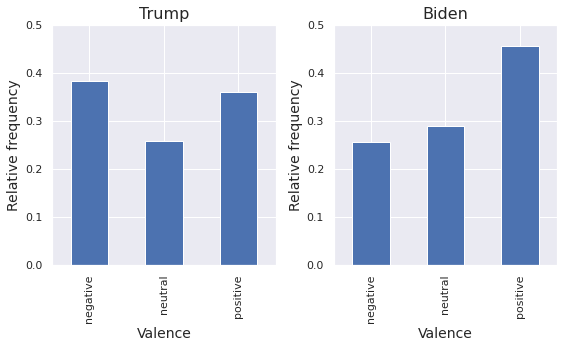

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

trump_tmp = get_valence_relative_freq(df_trump)
biden_tmp = get_valence_relative_freq(df_biden)

# plt.figure(figsize=(8,6))
fig, axes = plt.subplots(1, 2, figsize=(8,5))
# fig.suptitle('Vader sentiment analysis - \nrelative frequency per valence type for each candidate', fontsize=16)
# fig.tight_layout()

# sns.barplot(trump_tmp.index, trump_tmp.values, ax=axes[0])
(trump_tmp).plot(kind='bar', ax = axes[0])
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Valence', fontsize = 14)
axes[0].set_ylabel('Relative frequency', fontsize = 14)
axes[0].set_ylim(0, .5)

# ax2 = sns.countplot(x="comp_score", data=biden_tmp)
# sns.barplot(biden_tmp.index, biden_tmp.values,  ax=axes[1])
(biden_tmp).plot(kind='bar', ax = axes[1])
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Valence', fontsize = 14)
axes[1].set_ylabel('Relative frequency', fontsize = 14)
axes[1].set_ylim(0, .5)

plt.tight_layout()
plt.show()

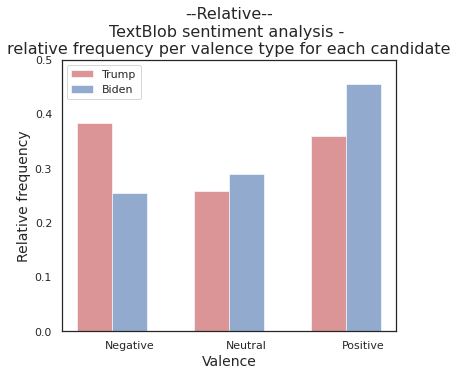

In [ ]:
plt.figure(figsize=(6,5))
sns.set_style("white")

ax = plt.gca()
ax.set_title('--Relative--\nTextBlob sentiment analysis - \nrelative frequency per valence type for each candidate', fontsize=16)

features = np.array([1,2,3])

trump = get_valence_relative_freq(df_trump)
ax.bar(features-0.3, trump.values, width=0.3, align = 'center', color = 'r', alpha= .6)

biden = get_valence_relative_freq(df_biden)
ax.bar(features, biden.values, width=0.3, align = 'center', color = 'b', alpha= .6)

ax.set_ylim(0, .5)
ax.set_xlabel('Valence', fontsize = 14)
ax.set_ylabel('Relative frequency', fontsize = 14)

ax.set_xticklabels(['', '', 'Negative', '', 'Neutral', '', 'Positive'])

labels= ["Trump", "Biden"]
ax.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

-0.023529456539096782
0.12472370745295384


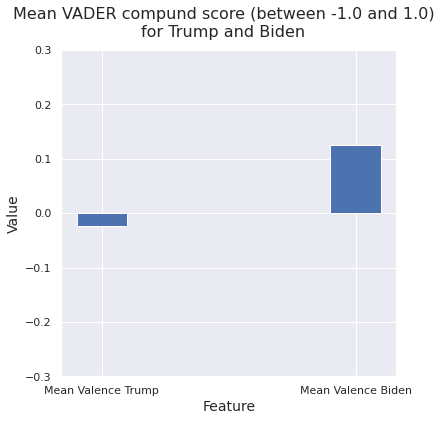

In [ ]:
print(df_trump['vader_polarity'].mean())
print(df_biden['vader_polarity'].mean())

sns.set_theme(style="darkgrid")

fig = plt.figure(figsize=(6,6))

fig.suptitle('Mean VADER compund score (between -1.0 and 1.0)\nfor Trump and Biden', fontsize=16)

features = ['Mean Valence Trump', 'Mean Valence Biden']
values = [df_trump['vader_polarity'].mean(), df_biden['vader_polarity'].mean()]

plt.bar(features,values, width=0.2)

axes = plt.gca()
axes.set_ylim(-.3, .3)
axes.set_xlabel('Feature', fontsize = 14)
axes.set_ylabel('Value', fontsize = 14)

plt.show()

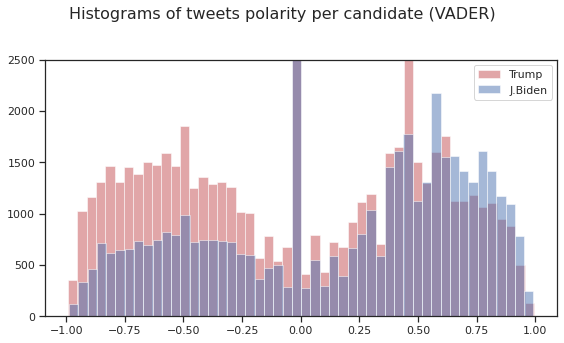

In [ ]:
sns.set_theme(style='ticks')

bins = 50

fig = plt.figure(figsize=(8,5))
fig.suptitle('Histograms of tweets polarity per candidate (VADER)', fontsize=16)

plt.hist(df_trump['vader_polarity'], bins = bins, alpha = 0.5, color = 'r')
plt.hist(df_biden['vader_polarity'], bins = bins, alpha = 0.5, color = 'b')

axes = plt.gca()
axes.set_ylim(0, 2500)

labels= ["Trump", "J.Biden"]
axes.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

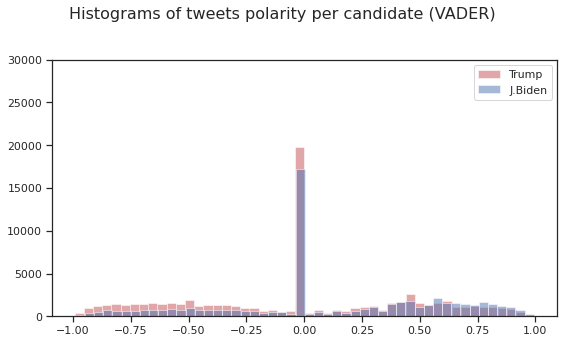

In [ ]:
bins = 50

fig = plt.figure(figsize=(8,5))
fig.suptitle('Histograms of tweets polarity per candidate (VADER)', fontsize=16)

plt.hist(df_trump['vader_polarity'], bins = bins, alpha = 0.5, color = 'r')
plt.hist(df_biden['vader_polarity'], bins = bins, alpha = 0.5, color = 'b')

axes = plt.gca()
axes.set_ylim(0, 30000)

labels= ["Trump", "J.Biden"]
axes.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

In [ ]:
classifier = TextClassifier.load('en-sentiment')

2021-04-26 10:33:55,518 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpkv6l7146


100%|██████████| 265512723/265512723 [00:16<00:00, 16444775.37B/s]

2021-04-26 10:34:12,174 copying /tmp/tmpkv6l7146 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-04-26 10:34:12,920 removing temp file /tmp/tmpkv6l7146
2021-04-26 10:34:13,019 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


# Flair

In [ ]:
sentence = Sentence('Trump is the best president ever!')
classifier.predict(sentence)

print('The resulting sentiment from the sentence above is: ', sentence.labels)

The resulting sentiment from the sentence above is:  [POSITIVE (0.9921)]


In [ ]:
def flair_make_sentences(text):
    """ Break apart text into a list of sentences """
    sentences = [sent for sent in split_single(text)]
    return sentences

def flair_predict_sentences(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = text.to_dict()['labels'][0]['confidence']
    else:
        result = -(text.to_dict()['labels'][0]['confidence'])
    return round(result, 3)

def flair_get_scores_per_sentences(sentences):
    """ Call predict on every sentence of a text """
    results = []
    
    for i in range(0, len(sentences)): 
        results.append(flair_predict_sentences(sentences[i]))
    results.append(flair_predict_sentences(sentences[0]))
    return results

def flair_get_sum(scores):
    result = round(sum(scores), 3)
    return result

def flair_get_avg_from_sentences(scores):
    result = round(np.mean(scores), 3)
    return result

def flair_get_score_tweet(text):
  if not text:
    return 0
  s = Sentence(text)
  classifier.predict(s)
  value = s.labels[0].to_dict()['value'] 
  if value == 'POSITIVE':
    result = s.to_dict()['labels'][0]['confidence']
  else:
    result = -(s.to_dict()['labels'][0]['confidence'])
  return round(result, 3)

def sentiment_analysis_flair(polarity):
  if polarity > 0:
    return 'positive'
  if polarity == 0:
    return 'neutral'
  if polarity < 0:
    return 'positive'

In [ ]:
records = 1000
temp = df_tweets_nltk[df_tweets_nltk.ds=='trump'][:records].copy()

start = time.time()

#flair sentiment by diving tweet into sentences and averaging
temp['sentences'] = temp['clean_tweet_nltk'].apply(flair_make_sentences)
temp['scores'] = temp['sentences'].apply(flair_get_scores_per_sentences)
temp['flair_scores_avg'] = temp.scores.apply(flair_get_avg_from_sentences)

#flair sentiment on the whole tweet
temp['flair_one_score'] = temp['clean_tweet_nltk'].apply(flair_get_score_tweet)

stop = time.time()
print(round((stop-start)/60, 3))

3.449


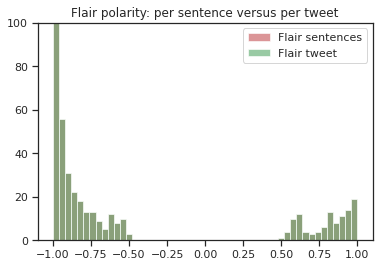

In [ ]:
bins = 50
alpha = 0.6
fig = plt.plot(figsize=(6,5))

plt.title('Flair polarity: per sentence versus per tweet')
ax = plt.gca()

ax.hist(temp['flair_scores_avg'], bins = bins, alpha = alpha, color = 'r')
ax.hist(temp['flair_one_score'], bins = bins, alpha = alpha, color = 'g')

ax.set_ylim(0, 100)
labels= ["Flair sentences", "Flair tweet"]
ax.legend(labels)
plt.show()

In [ ]:
temp['flair_sentiment'] = temp['flair_one_score'].apply(sentiment_analysis_flair)

# Comparison of all 3

In [ ]:
from sklearn.metrics import accuracy_score

print(f"Agreement between TextBlob - VADER: {accuracy_score(temp['blob_sentiment'],temp['vader_sentiment']):.4}")
print(f"Agreement between TextBlob - Flair: {accuracy_score(temp['blob_sentiment'],temp['flair_sentiment']):.4}")
print(f"Agreement between VADER - Flair: {accuracy_score(temp['vader_sentiment'],temp['flair_sentiment']):.4}")

Agreement between TextBlob - VADER: 0.532
Agreement between TextBlob - Flair: 0.31
Agreement between VADER - Flair: 0.379


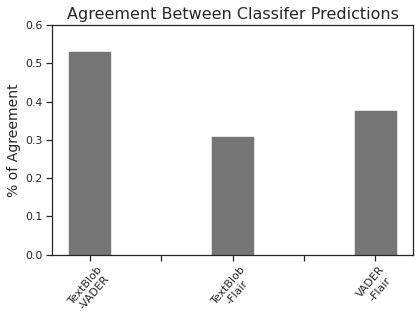

In [ ]:
fig = plt.figure(figsize=(6,6))

ax = plt.gca()
ax.set_title('Agreement Between Classifer Predictions', fontsize=16)

features = np.array([1,2,3])
values = [accuracy_score(temp['blob_sentiment'],temp['vader_sentiment']), accuracy_score(temp['blob_sentiment'],temp['flair_sentiment']), accuracy_score(temp['vader_sentiment'],temp['flair_sentiment'])]

ax.bar(features, values, width=0.3, align = 'center', color = 'k', alpha= .6)

ax.set_ylim(0, .6)
#ax.set_xlabel('Valence', fontsize = 14)
ax.set_ylabel('% of Agreement', fontsize = 14)

ax.set_xticklabels(['', 'TextBlob\n-VADER', '', 'TextBlob\n-Flair', '', 'VADER\n-Flair'], rotation=50)


fig.tight_layout(rect=[0, 0.03, 1, 0.80])
plt.show()

In [ ]:
def consensus(row):
    count = 0
    count += row['blob_sentiment']==row['vader_sentiment']
    count += row['blob_sentiment']==row['flair_sentiment']
    count += row['vader_sentiment']==row['flair_sentiment']

    return count

temp['consensus'] = temp.apply(lambda row: consensus(row), axis=1)

print(temp['consensus'].value_counts())

1    681
3    180
0    139
Name: consensus, dtype: int64


In [ ]:
(temp[temp['consensus']==0])[['tweet', 'clean_tweet_nltk', 'blob_sentiment', 'vader_sentiment', 'flair_sentiment']].tail(10)

,tweet,clean_tweet_nltk,blob_sentiment,vader_sentiment,flair_sentiment
59821,"@KingAlsacian @owtaspAs @lurkingwolf45 @MarkDice ...actually, the “WORLD” wouldn’t mind #Trump in prison either!",actually world mind trump prison either,neutral,negative,positive
59827,.-.\nWTH YOU HAVE TO LOSE?!\n\n#DonaldTrump is attacking #FakeNews\nPissed off from lackluster reviews\n.he thinks he’s enchanting\n.while raving &amp; ranting\n&amp; shouting WHAT DO U HAVE TO LOSE!!!\n\n #TraitorTrump #traitorgop\n#Election2020\n#BidenHarrisToSaveAmerica\n\nhttps://t.co/rLMNbJ...,wth lose donaldtrump attack fakenews piss lackluster review think enchant rave amp rant amp shout lose traitortrump traitorgop bidenharristosaveamerica,neutral,negative,positive
59829,In Case Anybody Is Still Unclear On Fact That Giuliani Is As Big A Racist A**hole As #Trump Is . #Vote2020 #VoteOutRacism #VoteOutHate #VoteOutTrump\nhttps://t.co/PR09j0too1 via @thedailybeast,case anybody unclear fact giuliani big racist trump voteoutracism voteouthate voteouttrump,neutral,negative,positive
59831,".-.\nPEACOCKY BETRAYAL\n\nTonight some will watch #Trump distract\nAnd create an alternative fact\n..but #NBC’s depraved\n..cuz when asked, they caved\nAnd betrayed their #Fairness contract. \n\n#TrumpIsALoser #NBCIsTrumpsAccomplice #NBCBlackout #TraitorInChief \n\nhttps://t.co/RazaFjhImr",peacocky betrayal tonight watch trump distract create alternative fact nbc deprave ask cave betrayed fairness contract trumpisaloser nbcistrumpsaccomplice nbcblackout traitorinchief,neutral,negative,positive
59833,"Is America not being ""double crossed"" &amp; deceived when POTUS wants #AmyConeyBarrett on #SCOTUS for her opposition to #Obamacare #RoeVsWade #VotingRights but Judge says that she doesn't know why #DonaldTrump nominated her. #SCOTUSHearing #SenateJudiciaryCommittee #FoxNews #CNN https://t.co/vC6...",america double cross amp deceive potus want amyconeybarrett scotus opposition obamacare roevswade votingrights judge say know donaldtrump nominate scotushearing senatejudiciarycommittee foxnews cnn,neutral,negative,positive
59838,@thinkingtime55 I really believe it is too close and I’m worried that we will lose to a cheating #Trump. GET OUT AND VOTE!!! GIVE BIDEN A GIANT🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊🌊VICTORY!!,believe close worried lose cheat trump vote biden,neutral,negative,positive
59848,So @SHO_Dexter came back to take @realDonaldTrump and @JoeBiden out the game right? \n\n#DexterReturns #Dexter #Dexter10 #trump #BidenCrimeFamily #ChickenTrump,come game right dexterreturns dexter trump bidencrimefamily chickentrump,negative,neutral,positive
59865,Check out my latest cartoon on @TinyviewComics! #HerdMentality #HerdImmunity #Trump #SocialDistancing #MaskUp https://t.co/tVPg8z7vO2,check late cartoon herdmentality herdimmunity trump socialdistancing maskup,negative,neutral,positive
59874,@fox32news #Trump disciples killing police was not on my hellscape bingo card.,trump disciple kill police hellscape bingo card,neutral,negative,positive
59875,"It’s just 19 days until #Election2020 Plenty to discuss with @MLRoberts360 on #TheAmericanChronicle including voter enthusiasm, Republican targeting of white, male, non-college or educated first time voters, and how fear of #woke policies could lead to a second term for #Trump",day plenty discus theamericanchronicle include voter enthusiasm republican target white male educate time voter fear woke policy lead second term trump,neutral,negative,positive


In [ ]:
df_trump['vader_clean_sentiment'].value_counts()

negative    29055
positive    26973
neutral     19120
Name: vader_clean_sentiment, dtype: int64

In [ ]:
df_biden['vader_clean_sentiment'].value_counts()

positive    27490
neutral     16561
negative    14825
Name: vader_clean_sentiment, dtype: int64

In [ ]:
df_biden.to_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_biden_vader.csv',index=False)

In [ ]:
df_trump.to_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_trump_vader.csv',index=False)

In [ ]:
df_biden_vader = pd.read_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_biden_vader.csv')
df_trump_vader = pd.read_csv('/content/drive/MyDrive/CIND_820/Data/temp_data/df_trump_vader.csv')

In [ ]:
df_biden_vader.shape

(58876, 28)

In [ ]:
df_biden_vader.drop(df_biden_vader.loc[df_biden_vader['vader_clean_sentiment']=='neutral'].index, inplace=True)

In [ ]:
df_biden_vader.shape

(42315, 28)

In [ ]:
encode_num = {"vader_clean_sentiment":     {"positive": 1, "negative": 0}}

In [ ]:
df_biden_vader = df_biden_vader.replace(encode_num)
df_biden_vader.head(3)

,created_at,tweet_id,tweet,likes,retweet_count,user_id,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,lang,ds,tokenized_tweet_nltk,clean_tweet_nltk,blob_polarity,blob_subjectivity,blob_sentiment,vader_clean_scores,vader_clean_polarity,vader_clean_sentiment,vader_scores,vader_polarity,vader_sentiment
0,2020-10-15 00:01:47,1.316530e+18,Twitter is doing everything they can to help D...,1.0,0.0,1.139962e+18,2.0,"Hollywood, FL",34.098003,-118.329523,Los Angeles,United States of America,North America,California,CA,en,biden,"['twitter', 'help', 'democrat', 'win', 'electi...",twitter help democrat win election make sure s...,0.175,0.522222,positive,"{'neg': 0.253, 'neu': 0.445, 'pos': 0.301, 'co...",0.1027,1,"{'neg': 0.18, 'neu': 0.607, 'pos': 0.214, 'com...",0.1027,positive
3,2020-10-15 00:03:17,1.316530e+18,"Hunter #Biden introduced his father, then-Vice...",1.0,0.0,1.936873e+08,2418.0,"New York, USA",40.712728,-74.006015,New York,United States of America,North America,New York,NY,en,biden,"['hunter', 'biden', 'introduce', 'father', 'pr...",hunter biden introduce father president joe bi...,-0.200,0.400000,negative,"{'neg': 0.166, 'neu': 0.758, 'pos': 0.076, 'co...",-0.3612,0,"{'neg': 0.1, 'neu': 0.81, 'pos': 0.09, 'compou...",-0.1027,negative
5,2020-10-15 00:03:49,1.316530e+18,@realDonaldTrump #TrumpIsALaughingStock @realD...,0.0,0.0,9.146945e+17,295.0,"Boca Raton, Florida USA",26.358688,-80.083098,Boca Raton,United States of America,North America,Florida,FL,en,biden,"['trumpisalaughingstock', 'iowa', 'cult', 'ral...",trumpisalaughingstock iowa cult rally compare ...,-0.125,0.750000,negative,"{'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'comp...",0.0772,1,"{'neg': 0.0, 'neu': 0.957, 'pos': 0.043, 'comp...",0.0772,positive


# Brute force - BOW

In [ ]:
biden_pos = df_biden_vader[df_biden_vader["vader_clean_sentiment"] ==1].sample(n=10000)
biden_neg = df_biden_vader[df_biden_vader["vader_clean_sentiment"] ==0].sample(n=10000)
# biden_neu = df_biden_vader[df_biden_vader.vader_clean_sentiment =='neutral'].sample(n=10000)
biden_all = pd.concat([biden_pos, biden_neg])
biden_all.shape

(20000, 28)

In [ ]:
Y = biden_all['vader_clean_sentiment'].values
X = biden_all['tokenized_tweet_nltk'].values
print(Y.shape)
print(type(Y))
print(X.shape)
print(type(X))

(20000,)
<class 'numpy.ndarray'>
(20000,)
<class 'numpy.ndarray'>


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=12)
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2,random_state=12)
print('='*100)
print("After splitting")
print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

After splitting
(16000,) (16000,)
(4000,) (4000,)
(4000,) (4000,)


In [ ]:
vectorizer=CountVectorizer()
vectorizer=vectorizer.fit(X_train)
X_train_bow=vectorizer.transform(X_train)
X_cv_bow=vectorizer.transform(X_cv)
X_test_bow=vectorizer.transform(X_test)
print('='*100)
print("After transform")
print(X_train_bow.shape,Y_train.shape)
print(X_cv_bow.shape,Y_cv.shape)
print(X_test_bow.shape,Y_cv.shape)

After transform
(16000, 17788) (16000,)
(4000, 17788) (4000,)
(4000, 17788) (4000,)


In [ ]:
print(Y_train.shape)
print(Y_cv.shape)

(16000,)
(4000,)


In [ ]:
from tqdm import tqdm
import os


100%|██████████| 15/15 [01:52<00:00,  7.49s/it]


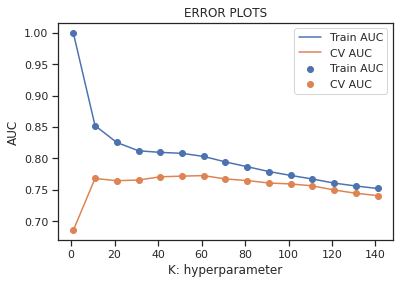

In [ ]:
train_auc = []
cv_auc = []
K = list(range(1, 150, 10))
for i in tqdm (K):
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
neighbors = list(range(80, 100, 2))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train_bow, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())


100%|██████████| 10/10 [01:01<00:00,  6.14s/it]


_____________________________________________________________________________________________________
Optimal number of neighbors:  82
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.327 0.327 0.329 0.332 0.332 0.335 0.338 0.339 0.339 0.339]
_____________________________________________________________________________________________________


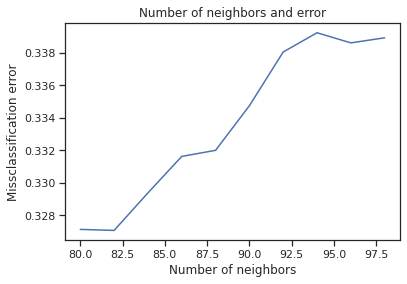

In [ ]:
MSE = [1 - x for x in cv_score]
optimal_k1 = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k1)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [ ]:
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k1,algorithm='brute')
optimal_model.fit(X_train_bow, Y_train)
prediction = optimal_model.predict(X_test_bow)

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

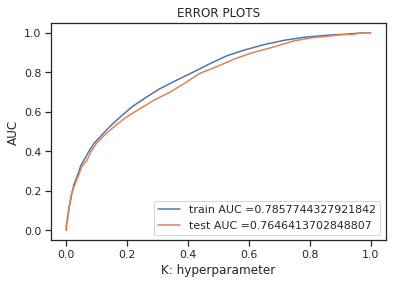

In [ ]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_bow)[:,1])
AUC1=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
training_accuracy = optimal_model.score(X_train_bow, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.705625
Train Error:  0.29437500000000005
Test Accuracy:  0.68475
Test Error:  0.31525000000000003
_____________________________________________________________________________________________________


In [ ]:
from sklearn.metrics import confusion_matrix

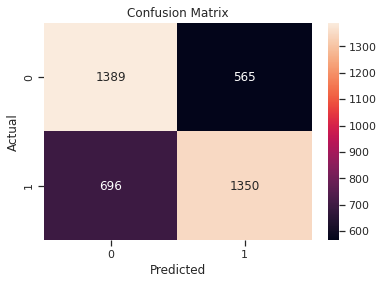

_____________________________________________________________________________________________________


In [ ]:
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(X_test_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1954
           1       0.70      0.66      0.68      2046

    accuracy                           0.68      4000
   macro avg       0.69      0.69      0.68      4000
weighted avg       0.69      0.68      0.68      4000



# Brute force TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit(X_train)
X_train_tfidf= tf_idf_vect.transform(X_train)
X_cv_tfidf=tf_idf_vect.transform(X_cv)
X_test_tfidf=tf_idf_vect.transform(X_test)


100%|██████████| 40/40 [06:37<00:00,  9.94s/it]


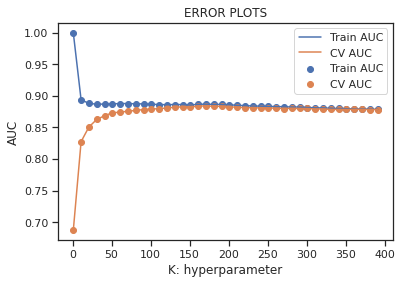

In [ ]:
train_auc = []
cv_auc = []
K = list(range(1, 400, 10))
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(X_train_tfidf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred =  neigh.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
neighbors = list(range(151, 400,10))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train_tfidf, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())       


100%|██████████| 25/25 [03:25<00:00,  8.24s/it]


_____________________________________________________________________________________________________
Optimal number of neighbors:  161
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.208 0.208 0.211 0.209 0.211 0.211 0.211 0.211 0.211 0.211 0.21  0.208
 0.209 0.211 0.21  0.211 0.21  0.211 0.21  0.212 0.211 0.211 0.213 0.213
 0.213]
_____________________________________________________________________________________________________


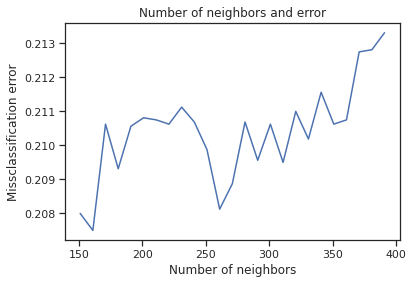

In [ ]:
MSE = [1 - x for x in cv_score]
optimal_k2 = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k2)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [ ]:
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k2, algorithm='brute')
optimal_model.fit(X_train_tfidf, Y_train)
prediction = optimal_model.predict(X_test_tfidf)

In [ ]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_tfidf)[:,1])
AUC2=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

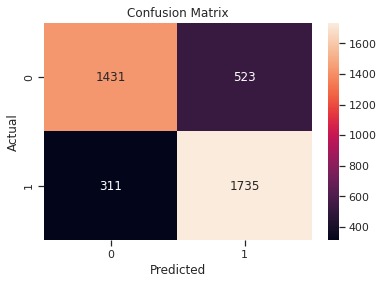

_____________________________________________________________________________________________________


In [ ]:
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(X_test_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1954
           1       0.77      0.85      0.81      2046

    accuracy                           0.79      4000
   macro avg       0.79      0.79      0.79      4000
weighted avg       0.79      0.79      0.79      4000



# KNN kd-tree

In [ ]:
biden_pos2 = df_biden_vader[df_biden_vader["vader_clean_sentiment"] ==1].sample(n=10000)
biden_neg2 = df_biden_vader[df_biden_vader["vader_clean_sentiment"] ==0].sample(n=10000)
# biden_neu = df_biden_vader[df_biden_vader.vader_clean_sentiment =='neutral'].sample(n=10000)
biden_all2 = pd.concat([biden_pos2, biden_neg2])
biden_all2.shape

(20000, 28)

In [ ]:
B = biden_all2['vader_clean_sentiment'].values
A = biden_all2['tokenized_tweet_nltk'].values
print(B.shape)
print(type(B))
print(A.shape)
print(type(B))

(20000,)
<class 'numpy.ndarray'>
(20000,)
<class 'numpy.ndarray'>


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

A_train,A_test,B_train,B_test=train_test_split(A,B,test_size=0.2,random_state=12)
A_train,A_cv,B_train,B_cv=train_test_split(A,B,test_size=0.2,random_state=12)
print('='*100)
print("After splitting")
print(A_train.shape,B_train.shape)
print(A_cv.shape,B_cv.shape)
print(A_test.shape,B_test.shape)

After splitting
(16000,) (16000,)
(4000,) (4000,)
(4000,) (4000,)


In [ ]:
vectorizer=CountVectorizer(min_df=10, max_features=500)
vectorizer=vectorizer.fit(A_train)
A_train_bow_kdtree=vectorizer.transform(A_train)
A_cv_bow_kdtree=vectorizer.transform(A_cv)
A_test_bow_kdtree=vectorizer.transform(A_test)
print('='*100)
print("After transform")
print(A_train_bow_kdtree.shape,B_train.shape)
print(A_cv_bow_kdtree.shape,B_cv.shape)
print(A_test_bow_kdtree.shape,B_cv.shape)

After transform
(16000, 500) (16000,)
(4000, 500) (4000,)
(4000, 500) (4000,)


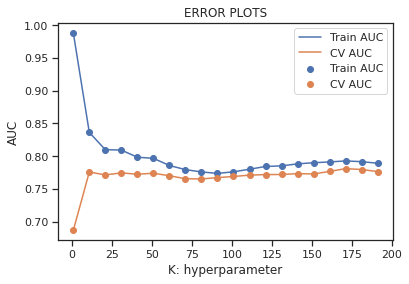

In [ ]:
train_auc = []
cv_auc = []
K = list(range(1,200,10))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(A_train_bow_kdtree.todense(), B_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    B_train_pred =  neigh.predict_proba(A_train_bow_kdtree.todense())[:,1]
    B_cv_pred =  neigh.predict_proba(A_cv_bow_kdtree.todense())[:,1]
    
    train_auc.append(roc_auc_score(B_train,B_train_pred))
    cv_auc.append(roc_auc_score(B_cv, B_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
neighbors = list(range(31, 71, 2))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, A_train_bow_kdtree.todense(), B_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())


100%|██████████| 20/20 [1:29:15<00:00, 267.79s/it]


_____________________________________________________________________________________________________
Optimal number of neighbors:  31
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.325 0.326 0.326 0.329 0.33  0.329 0.331 0.332 0.333 0.335 0.334 0.334
 0.336 0.338 0.338 0.338 0.337 0.337 0.339 0.34 ]
_____________________________________________________________________________________________________


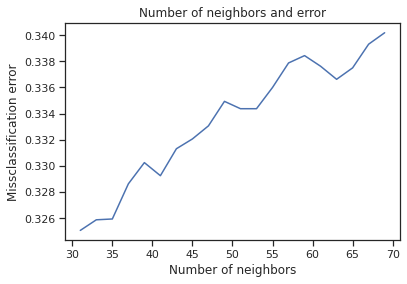

In [ ]:
MSE = [1 - x for x in cv_score]
optimal_k5 = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k5)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [ ]:
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k5,algorithm='kd_tree')
optimal_model.fit(A_train_bow_kdtree.todense(), B_train)
prediction = optimal_model.predict(A_test_bow_kdtree.todense())

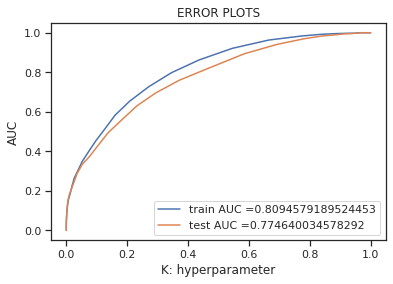

In [ ]:
train_fpr, train_tpr, thresholds = roc_curve(B_train, optimal_model.predict_proba(A_train_bow_kdtree.todense())[:,1])
test_fpr, test_tpr, thresholds = roc_curve(B_test, optimal_model.predict_proba(A_test_bow_kdtree.todense())[:,1])
AUC5=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
training_accuracy = optimal_model.score(A_train_bow_kdtree.todense(), B_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(B_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.7120625
Train Error:  0.28793749999999996
Test Accuracy:  0.68575
Test Error:  0.31425000000000003
_____________________________________________________________________________________________________


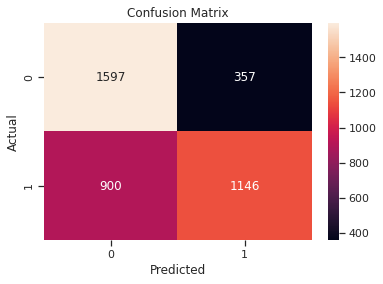

_____________________________________________________________________________________________________


In [ ]:
conf_matrix = confusion_matrix(B_test, optimal_model.predict(A_test_bow_kdtree.todense()))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(B_test, prediction))

              precision    recall  f1-score   support

           0       0.64      0.82      0.72      1954
           1       0.76      0.56      0.65      2046

    accuracy                           0.69      4000
   macro avg       0.70      0.69      0.68      4000
weighted avg       0.70      0.69      0.68      4000



# TIFDF - tree

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=100)
tf_idf_vect.fit(A_train)
A_train_tfidf =tf_idf_vect.transform(A_train)
A_cv_tfidf=tf_idf_vect.transform(A_cv)
A_test_tfidf=tf_idf_vect.transform(A_test)
print(A_train_tfidf.shape)

(16000, 7725)


In [ ]:
train_auc = []
cv_auc = []
K = list(range(1,200,10))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(A_train_tfidf.todense(), B_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    B_train_pred =  neigh.predict_proba(A_train_tfidf.todense())[:,1]
    B_cv_pred =  neigh.predict_proba(A_cv_tfidf.todense())[:,1]
    
    train_auc.append(roc_auc_score(B_train,B_train_pred))
    cv_auc.append(roc_auc_score(B_cv, B_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
neighbors = list(range(109,125,2))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, A_train_tfidf.todense(), B_train, cv=3, scoring='accuracy')
    cv_score.append(scores.mean())

NameError: ignored

In [ ]:
MSE = [1 - x for x in cv_score]
optimal_k6 = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k6)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [ ]:
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k6, algorithm='kd_tree')
optimal_model.fit(A_train_tfidf.todense(), B_train)
prediction = optimal_model.predict(A_test_tfidf.todense())

In [ ]:
train_fpr, train_tpr, thresholds = roc_curve(B_train, optimal_model.predict_proba(A_train_tfidf.todense())[:,1])
test_fpr, test_tpr, thresholds = roc_curve(B_test, optimal_model.predict_proba(A_test_tfidf.todense())[:,1])
AUC6=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [ ]:
training_accuracy = optimal_model.score(A_train_tfidf.todense(), B_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(B_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

In [ ]:
conf_matrix = confusion_matrix(B_test, optimal_model.predict(A_test_tfidf.todense()))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(B_test, prediction))

In [ ]:
from prettytable import PrettyTable
comparison = PrettyTable()
comparison.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
comparison.add_row(["BOW", 'brute', optimal_k1, np.round(float(AUC1),3)])
comparison.add_row(["TFIDF", 'brute', optimal_k2, np.round(float(AUC2),3)])

comparison.add_row(["BOW", 'kd_tree', optimal_k5, np.round(float(AUC5),3)])
comparison.add_row(["TFIDF", 'kd_tree', optimal_k6, np.round(float(AUC6),3)])

print(comparison)

# Insights

In [ ]:
rel_senti = df_tweets_nltk[['state','vader_clean_polarity','ds']].groupby(['state','ds']).mean()
rel_senti.reset_index(inplace = True)

In [ ]:
rel_senti.head(6)

,state,ds,vader_clean_polarity
0,Alabama,biden,0.116889
1,Alabama,trump,-0.010295
2,Alaska,biden,0.162138
3,Alaska,trump,-0.064447
4,Arizona,biden,0.101238
5,Arizona,trump,-0.018416


In [ ]:
# checking to see if all 52 States per candidate are present; there should be a total of a 104
rel_senti.shape

(103, 3)

There is only a total of a 103 States which indicates that one State is missing; i.e. no one tweeted about the candidate from that State

In [ ]:
total_test = (rel_senti.state.value_counts()!=2).reset_index()
total_test[total_test.state == True]

,index,state
51,South Dakota,True


In [ ]:
rel_senti[rel_senti.state=='South Dakota']

,state,ds,vader_clean_polarity
84,South Dakota,biden,0.15873


In [ ]:
rel_senti = rel_senti.append({'state': 'South Dakota', 'ds':'trump', 'vader_clean_polarity':0}, ignore_index=True)
rel_senti.sort_values('state', ascending=True, inplace=True)
rel_senti.reset_index(drop=True)

,state,ds,vader_clean_polarity
0,Alabama,biden,0.116889
1,Alabama,trump,-0.010295
2,Alaska,biden,0.162138
3,Alaska,trump,-0.064447
4,Arizona,biden,0.101238
...,...,...,...
99,West Virginia,trump,-0.055240
100,Wisconsin,biden,0.167222
101,Wisconsin,trump,-0.019822
102,Wyoming,biden,0.038167


In [ ]:
rel_senti = rel_senti[['state','vader_clean_polarity']].groupby('state')
rel_senti = rel_senti.diff(periods=-1)

In [ ]:
rel_senti.dropna(inplace=True)
rel_senti.reset_index(inplace = True, drop=True)
rel_senti.head(4)

,vader_clean_polarity
0,0.127184
1,0.226585
2,0.119655
3,0.331824


In [ ]:
states_df = pd.DataFrame(data=np.sort(df_tweets_nltk.state.unique()), columns=['state'])
rel_senti = rel_senti.join(states_df)
rel_senti.head(3)

,vader_clean_polarity,state
0,0.127184,Alabama
1,0.226585,Alaska
2,0.119655,Arizona


In [ ]:
geo_usa_df = pd.read_json('../input/a-simple-geojson-file-for-us-state/geo_usa.json')
geo_usa_df.head()